## Problem 6: U GANS vs VAEs on Fashion MNIST

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import random
import numpy as np

In [2]:
# Train a vanilla GAN and Variational Autoencoder (VAE) on the Fashion MNIST dataset using PyTorch. 
# We use a simple architecture consisting of fully connected layers for both the generator and discriminator of the GAN, 
# and fully connected layers for the encoder and decoder of the VAE.

# Set seed for reproducibility
random.seed(0)
torch.manual_seed(0)

# Set device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

# Load Fashion MNIST dataset
full_dataset = dsets.FashionMNIST(root='./data', train=True, transform=transform, download=True)

# Sample a subset of 30000 examples from the full dataset for GAN model training
subset_indices = random.sample(range(len(full_dataset)), 30000)
subset = torch.utils.data.Subset(full_dataset, subset_indices)
train_loader = torch.utils.data.DataLoader(subset, batch_size=64, shuffle=True)

# Next, define the generator and discriminator for the GAN
# Define the generator for the GAN
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()
        self.img_shape = img_shape
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

# Define the discriminator for the GAN
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()
        self.img_shape = img_shape
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

#### define the encoder and decoder for the VAE:
# Define the encoder for the VAE
class Encoder(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Encoder, self).__init__()
        self.img_shape = img_shape
        self.latent_dim = latent_dim
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
        )
        self.mean = nn.Linear(256, latent_dim)
        self.logvar = nn.Linear(256, latent_dim)

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        x = self.model(img_flat)
        mean = self.mean(x)
        logvar = self.logvar(x)
        return mean, logvar

# Define the decoder for the VAE
class Decoder(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Decoder, self).__init__()
        self.img_shape = img_shape
        self.latent_dim = latent_dim
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

# Now, define the loss functions and optimizers for both the GAN and VAE
# Define the loss function for the GAN
adversarial_loss = nn.BCELoss()

# Define the optimizers for the GAN
generator = Generator(latent_dim=100, img_shape=(1, 28, 28)).to(device)
discriminator = Discriminator(img_shape=(1, 28, 28)).to(device)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Define the loss function for the VAE
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_divergence

# Define the optimizers for the VAE
encoder = Encoder(latent_dim=20, img_shape=(1, 28, 28)).to(device)
decoder = Decoder(latent_dim=20, img_shape=(1, 28, 28)).to(device)
optimizer_E = torch.optim.Adam(encoder.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(decoder.parameters(), lr=0.0002, betas=(0.5, 0.999))

100%|██████████| 26421880/26421880 [00:01<00:00, 17426852.33it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 295813.24it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5507208.71it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22398627.59it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



# 1. GAN

In [3]:
# Train the GAN model, save the model weights every 5 epochs into the 'gan_weights' folder. 
# Then, save the final model weights after training is complete.

import os
# Create a folder to save the model weights
folder_path = 'gan_weights'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Set the number of epochs and batch size
num_epochs = 50
batch_size = 1024

# Initialize lists to store losses
d_losses = []
g_losses = []

# Train the GAN
for epoch in range(num_epochs):
    d_loss_epoch = 0.0
    g_loss_epoch = 0.0
    for i, (imgs, _) in enumerate(train_loader):
        # Adversarial ground truths
        valid = torch.ones((batch_size, 1)).to(device)
        fake = torch.zeros((batch_size, 1)).to(device)

        # Train the discriminator
        optimizer_D.zero_grad()
        real_imgs = imgs.to(device)
        fake_imgs = generator(torch.randn(batch_size, 100).to(device))
        real_loss = adversarial_loss(discriminator(real_imgs), valid[:real_imgs.size(0), :])
        fake_loss = adversarial_loss(discriminator(fake_imgs.detach()), fake[:fake_imgs.size(0), :])
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Train the generator
        optimizer_G.zero_grad()
        fake_imgs = generator(torch.randn(batch_size, 100).to(device))
        g_loss = adversarial_loss(discriminator(fake_imgs), valid[:fake_imgs.size(0), :])
        g_loss.backward()
        optimizer_G.step()

        # Update epoch losses
        d_loss_epoch += d_loss.item()
        g_loss_epoch += g_loss.item()

    # Compute average losses for epoch
    d_loss_epoch /= len(train_loader)
    g_loss_epoch /= len(train_loader)

    # Append losses to lists
    d_losses.append(d_loss_epoch)
    g_losses.append(g_loss_epoch)

    # Print training progress at every epoch
    print(f"[Epoch {epoch}/{num_epochs}] [D loss: {d_loss_epoch}] [G loss: {g_loss_epoch}]")

    # Save model weights every 5 epochs into 'gan_weights' folder
    if epoch % 5 == 0:
        torch.save({
            'generator': generator.state_dict(),
            'discriminator': discriminator.state_dict(),
            'optimizer_G': optimizer_G.state_dict(),
            'optimizer_D': optimizer_D.state_dict(),
        }, os.path.join(folder_path, f'gan_checkpoint_epoch_{epoch}.pth'))

# Save final model weights into 'gan_weights' folder
torch.save({
    'generator': generator.state_dict(),
    'discriminator': discriminator.state_dict(),
    'optimizer_G': optimizer_G.state_dict(),
    'optimizer_D': optimizer_D.state_dict(),
}, os.path.join(folder_path, 'gan_final_weights.pth'))


[Epoch 0/50] [D loss: 1.4324892055251197] [G loss: 0.13682059367010588]
[Epoch 1/50] [D loss: 1.4577669050139406] [G loss: 0.12192705322875143]
[Epoch 2/50] [D loss: 1.4590366120531615] [G loss: 0.12159822017017967]
[Epoch 3/50] [D loss: 1.4598622777060406] [G loss: 0.12138495058901529]
[Epoch 4/50] [D loss: 1.460305122678468] [G loss: 0.12127082966474582]
[Epoch 5/50] [D loss: 1.4604163271531876] [G loss: 0.12124184120311411]
[Epoch 6/50] [D loss: 1.4605141720537946] [G loss: 0.12121677559131244]
[Epoch 7/50] [D loss: 1.460587620989346] [G loss: 0.1211980123922769]
[Epoch 8/50] [D loss: 1.4606484421280657] [G loss: 0.1211818856502901]
[Epoch 9/50] [D loss: 1.460689204842297] [G loss: 0.12117108500906146]
[Epoch 10/50] [D loss: 1.460734852087269] [G loss: 0.12115970157039191]
[Epoch 11/50] [D loss: 1.4607731253861873] [G loss: 0.1211500847771732]
[Epoch 12/50] [D loss: 1.4608083518583383] [G loss: 0.12114163782042481]
[Epoch 13/50] [D loss: 1.4608364949094208] [G loss: 0.12113421071948

## 1.2 GAN loss plot

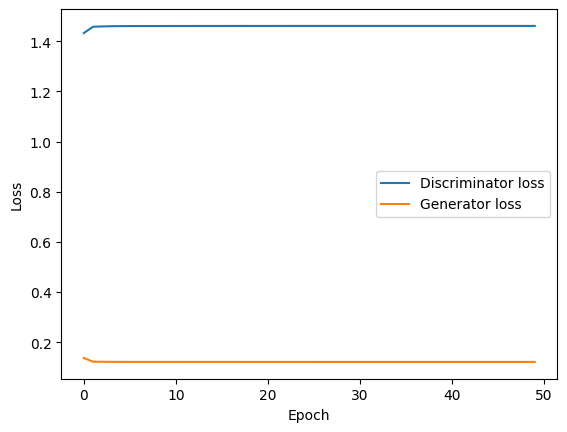

In [4]:
# Plot losses
import matplotlib.pyplot as plt

plt.plot(range(num_epochs), d_losses, label='Discriminator loss')
plt.plot(range(num_epochs), g_losses, label='Generator loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## 1.3 Using GAN, generate a sample of 25 fake images and plot the corresponding images

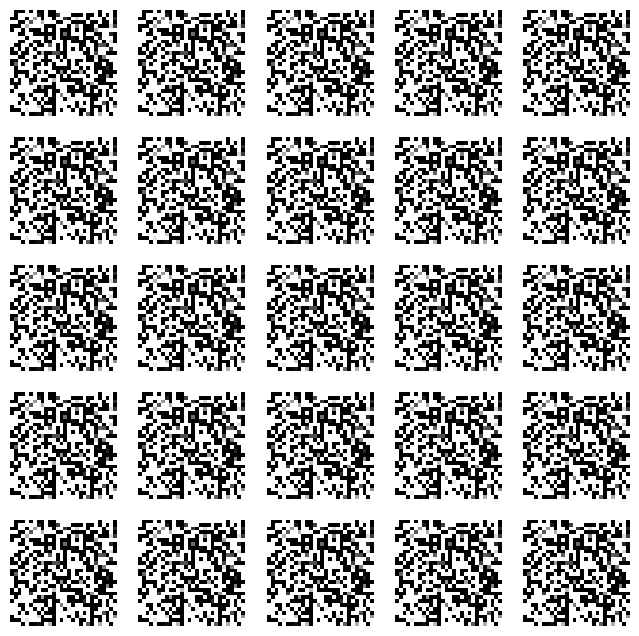

In [7]:
# Load the saved model weights
checkpoint = torch.load(os.path.join(folder_path, 'gan_final_weights.pth'))
generator.load_state_dict(checkpoint['generator'])

# Generate a sample of 25 fake images
with torch.no_grad():
    z = torch.randn(25, 100).to(device)
    fake_imgs = generator(z)

# Convert the fake images to numpy arrays
fake_imgs = fake_imgs.cpu().numpy()

# Rescale the fake images from [-1, 1] to [0, 1]
fake_imgs = (fake_imgs + 1) / 2

# Plot the fake images
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
for i in range(5):
    for j in range(5):
        axs[i, j].imshow(fake_imgs[i*5+j].reshape((28, 28)), cmap='gray')
        axs[i, j].axis('off')
plt.show()

In [1]:
## The vanilla GAN did not do a good job
## Fake images from the generator show that the GAN did not learn from the data. There can be several reasons:
## 1) The generator is stuck in a local minimum.
## 2) There isn't a good balance between the generator and discriminator. The discriminator can be too strong 
# that no matter what the generator outputs, the discriminator is able to distinguish the real from the fake images.
# Therefore, the generator is unable to improve.
## 3) To improve, we may need to look into Wasserstein GAN (WGAN), and use regularization on the discriminator or generator 
# that is too strong in order balance out the training progress.

# 2. Variational Autoencoder

In [2]:
# The VAE architecture consists of an encoder with two fully connected layers and a decoder with two fully connected layers. 
# The encoder outputs the mean and log variance of the latent variable, which are used to compute the KL divergence loss term. The decoder is used to reconstruct the input image from the sampled latent variable. The `reparameterize` function is used to sample from the latent variable using the mean and log variance. The `vae_loss` function computes the VAE loss, which is the sum of the mean squared error loss and the KL divergence loss. The VAE is trained using the Adam optimizer with a learning rate of 0.001 for both the encoder and decoder. The VAE is trained for 50 epochs, and the final model weights are saved to a file called 'vae_final_weights.pth'.
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define the VAE architecture
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc21 = nn.Linear(512, 20)
        self.fc22 = nn.Linear(512, 20)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        mu = self.fc21(x)
        logvar = self.fc22(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(20, 512)
        self.fc2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.fc1(z))
        x_hat = torch.tanh(self.fc2(z))
        return x_hat

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

def vae_loss(x_hat, x, mu, logvar):
    mse_loss = F.mse_loss(x_hat, x.view(-1, 784), reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return mse_loss + kl_loss

# Set device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

# Load Fashion MNIST dataset
train_dataset = dsets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define the VAE model, optimizer, and loss function
vae = VAE().to(device)
optimizer_E = optim.Adam(vae.encoder.parameters(), lr=0.001)
optimizer_D = optim.Adam(vae.decoder.parameters(), lr=0.001)

# Train the VAE model
num_epochs = 50
vae_losses = []
for epoch in range(num_epochs):
    vae_loss_epoch = 0.0
    for i, (imgs, _) in enumerate(train_loader):
        optimizer_E.zero_grad()
        optimizer_D.zero_grad()
        x = imgs.to(device)

        # Forward pass
        x_hat, mu, logvar = vae(x)

        # Compute loss
        loss = vae_loss(x_hat, x, mu, logvar)

        # Backward pass and optimize
        loss.backward()
        optimizer_E.step()
        optimizer_D.step()

        # Update epoch loss
        vae_loss_epoch += loss.item()

    # Compute average loss for epoch
    vae_loss_epoch /= len(train_loader)

    # Append loss to list
    vae_losses.append(vae_loss_epoch)

    # Print training progress
    print(f"[Epoch {epoch}/{num_epochs}] [VAE loss: {vae_loss_epoch}]")

# Save final model weights into 'vae_weights' folder
torch.save({
    'encoder': vae.encoder.state_dict(),
    'decoder': vae.decoder.state_dict(),
    'optimizer_E': optimizer_E.state_dict(),
    'optimizer_D': optimizer_D.state_dict(),
}, 'vae_final_weights.pth')



[Epoch 0/50] [VAE loss: 5804.955906329124]
[Epoch 1/50] [VAE loss: 4616.661853001316]
[Epoch 2/50] [VAE loss: 4422.015665343067]
[Epoch 3/50] [VAE loss: 4319.797353130414]
[Epoch 4/50] [VAE loss: 4246.09870543002]
[Epoch 5/50] [VAE loss: 4192.90337366946]
[Epoch 6/50] [VAE loss: 4152.832818330224]
[Epoch 7/50] [VAE loss: 4120.29134513676]
[Epoch 8/50] [VAE loss: 4090.6985818500966]
[Epoch 9/50] [VAE loss: 4068.9111203191633]
[Epoch 10/50] [VAE loss: 4050.38137550598]
[Epoch 11/50] [VAE loss: 4034.8337269602043]
[Epoch 12/50] [VAE loss: 4014.3184101291813]
[Epoch 13/50] [VAE loss: 4003.3298100388124]
[Epoch 14/50] [VAE loss: 3992.539830319663]
[Epoch 15/50] [VAE loss: 3981.6189534852247]
[Epoch 16/50] [VAE loss: 3968.314207032291]
[Epoch 17/50] [VAE loss: 3964.046532214069]
[Epoch 18/50] [VAE loss: 3954.973526098581]
[Epoch 19/50] [VAE loss: 3945.248815605635]
[Epoch 20/50] [VAE loss: 3937.6452628910415]
[Epoch 21/50] [VAE loss: 3930.096879971307]
[Epoch 22/50] [VAE loss: 3927.541055968

## 2.2 GAN loss plot

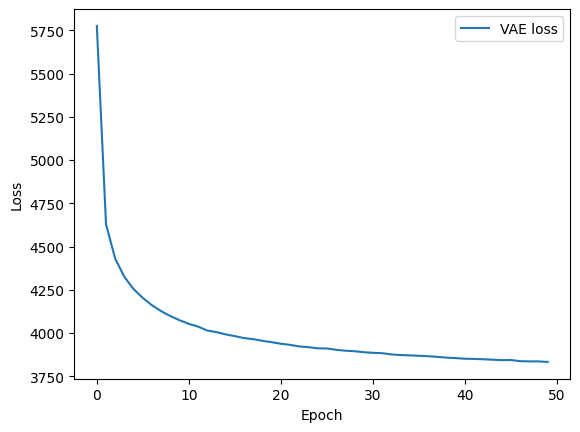

In [4]:
# Plot VAN losses
import matplotlib.pyplot as plt

plt.plot(range(num_epochs), vae_losses, label='VAE loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
# To improve model we can do the following:
# 1) Increase batch size
# 2) Train G, not D

## 2.3 Using VAE, generate a sample of 25 fake images and plot the corresponding images

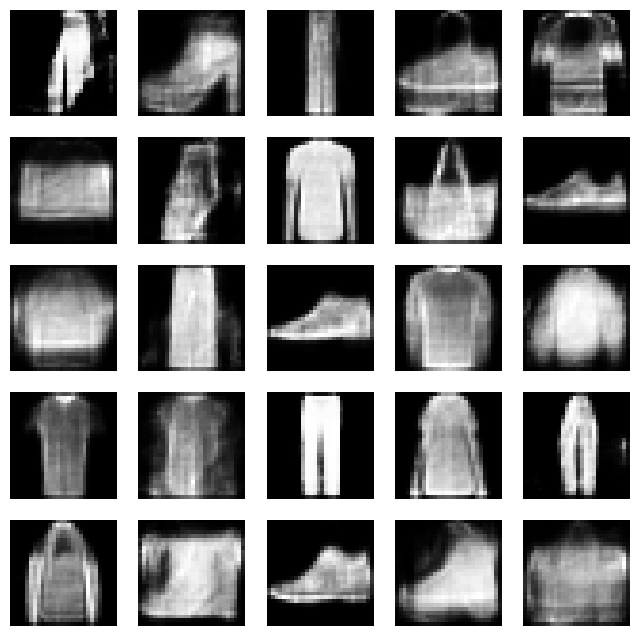

In [4]:
# Plot for VAE
# In this code, we first load the saved model weights into a new instance of the VAE model. 
# Then, we generate a sample of 25 fake images by sampling from the latent space using `torch.randn` and 
# passing the resulting tensor through the VAE decoder. 
# We convert the fake images to numpy arrays, rescale them from [-1, 1] to [0, 1], and then 
# plot them using matplotlib. The resulting plot shows 25 generated images in a 5x5 grid.

import matplotlib.pyplot as plt
import numpy as np

# Load the saved model weights
checkpoint = torch.load('vae_final_weights.pth')
vae = VAE().to(device)
vae.encoder.load_state_dict(checkpoint['encoder'])
vae.decoder.load_state_dict(checkpoint['decoder'])

# Generate a sample of 25 fake images
with torch.no_grad():
    z = torch.randn(25, 20).to(device)
    fake_imgs = vae.decoder(z)

# Convert the fake images to numpy arrays
fake_imgs = fake_imgs.cpu().numpy()

# Rescale the fake images from [-1, 1] to [0, 1]
fake_imgs = (fake_imgs + 1) / 2

# Plot the fake images
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
for i in range(5):
    for j in range(5):
        axs[i, j].imshow(fake_imgs[i*5+j].reshape((28, 28)), cmap='gray')
        axs[i, j].axis('off')
plt.show()


In [1]:
# VAE generated much better images than GAN.
## GAN is more difficult to train and takes longer because it is adversarial, there is the generator and discriminator.
## Overall, I would say that both GAN and VAE are powerful. But it may be hard to get hyperparameters right for the GAN model.